In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
%cd ./Auto-Piolot/lane_detection

/drive/.shortcut-targets-by-id/1cKuKUq8z-oix7l5wbuAltwtTIgvlR4A9/lane_detection


In [ ]:
!pip install -U albumentations>=0.3.0
!pip install -U --pre segmentation-models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 KB 6.6 MB/s eta 0:00:00


In [ ]:
import cv2, os, glob
import keras
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
DATA_DIR = './training/'
src_img = os.path.join(DATA_DIR, 'gt_image')
mask_img = os.path.join(DATA_DIR, 'gt_binary_image')

In [ ]:
train_ids = []
val_ids = []
test_ids = []

with open(DATA_DIR+'/train.txt','r') as f:
    data = f.readlines()
for sample in data:
    train_ids.append(sample.split(' ')[0].split('/')[-1])

with open(DATA_DIR+'/val.txt','r') as f:
    data = f.readlines()
for sample in data:
    val_ids.append(sample.split(' ')[0].split('/')[-1])

with open(DATA_DIR+'/test.txt','r') as f:
    data = f.readlines()
for sample in data:
    test_ids.append(sample.split(' ')[0].split('/')[-1])

In [ ]:
print('Train Samples: ', len(train_ids))
print('Validation Samples: ', len(val_ids))
print('Test Samples: ', len(test_ids))

Train Samples:  3300
Validation Samples:  326
Test Samples:  72520


In [ ]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap='gray')
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x

In [ ]:
# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['lane']
    
    def __init__(
            self,
            ids, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = ids
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloder(keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return batch
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes) 

In [ ]:
import albumentations as A

In [ ]:
def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.PadIfNeeded(min_height=480, min_width=640, always_apply=True, border_mode=0),
        A.Resize(480, 640, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
            A.PadIfNeeded(min_height=480, min_width=640),
            A.Resize(480, 640, always_apply=True),
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)

/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albumentations/augmentations/transforms.py:1149: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/usr/local/lib/python3.9/dist-packages/albument

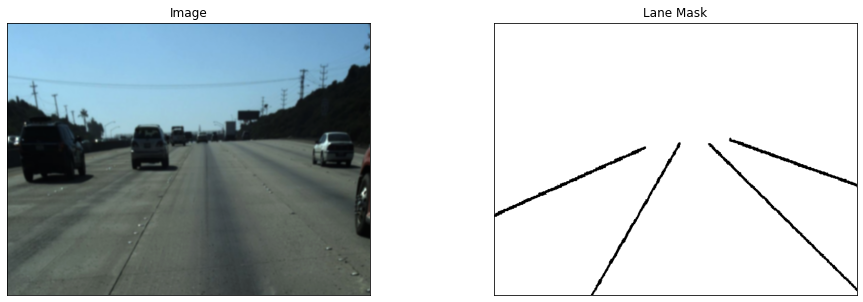

In [ ]:
# Lets look at augmented data we have
dataset = Dataset(train_ids, src_img, mask_img, classes=['lane'], augmentation=get_training_augmentation())

image, mask = dataset[0] # get some sample
visualize(
    image=image, 
    lane_mask=mask[..., 0].squeeze()
)

In [ ]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import segmentation_models as sm
sm.set_framework('tf.keras')

Segmentation Models: using `tf.keras` framework.


In [ ]:
BACKBONE = 'efficientnetb3'
BATCH_SIZE = 4
CLASSES = ['lane']
LR = 0.0001
EPOCHS = 40

preprocess_input = sm.get_preprocessing(BACKBONE)


In [ ]:
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

#create model
model = sm.Unet(BACKBONE, classes=n_classes, activation=activation)

44107200/44107200 [==============================] - 3s 0us/step


In [ ]:
# define optomizer
optim = keras.optimizers.Adam(LR)

# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

# actulally total_loss can be imported directly from library, above example just show you how to manipulate with losses
# total_loss = sm.losses.binary_focal_dice_loss # or sm.losses.categorical_focal_dice_loss 

metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]

# compile keras model with defined optimozer, loss and metrics
model.compile(optim, total_loss, metrics)


In [ ]:
# Dataset for train images
train_dataset = Dataset(
    train_ids,
    src_img, 
    mask_img, 
    classes=CLASSES, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

# Dataset for validation images
valid_dataset = Dataset(
    val_ids,
    src_img, 
    mask_img,
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

train_dataloader = Dataloder(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloder(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 480, 640, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 480, 640, n_classes)

# define callbacks for learning rate scheduling and best checkpoints saving
callbacks = [
    keras.callbacks.ModelCheckpoint('./best_model.h5', save_weights_only=True, save_best_only=True, mode='min'),
    keras.callbacks.ReduceLROnPlateau(),
]

In [ ]:
history = model.fit(
    train_dataloader, 
    steps_per_epoch=len(train_dataloader), 
    epochs=EPOCHS, 
    callbacks=callbacks, 
    validation_data=valid_dataloader, 
    validation_steps=len(valid_dataloader)
)

Epoch 1/40
825/825 [==============================] - 1655s 2s/step - loss: 0.1742 - iou_score: 0.9315 - f1-score: 0.9525 - val_loss: 0.0741 - val_iou_score: 0.9802 - val_f1-score: 0.9900 - lr: 1.0000e-04
Epoch 2/40
825/825 [==============================] - 515s 624ms/step - loss: 0.0526 - iou_score: 0.9815 - f1-score: 0.9907 - val_loss: 0.0423 - val_iou_score: 0.9809 - val_f1-score: 0.9904 - lr: 1.0000e-04
Epoch 3/40
825/825 [==============================] - 515s 624ms/step - loss: 0.0326 - iou_score: 0.9823 - f1-score: 0.9911 - val_loss: 0.0371 - val_iou_score: 0.9782 - val_f1-score: 0.9890 - lr: 1.0000e-04
Epoch 4/40
  9/825 [..............................] - ETA: 7:57 - loss: 0.0280 - iou_score: 0.9828 - f1-score: 0.9913

KeyboardInterrupt: ignored

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
test_dataset = Dataset(
    test_ids,
    src_img, 
    mask_img, 
    classes=CLASSES, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input),
)

test_dataloader = Dataloder(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# load best weights
model.load_weights('best_model.h5') 

1/1 [==============================] - 0s 66ms/step


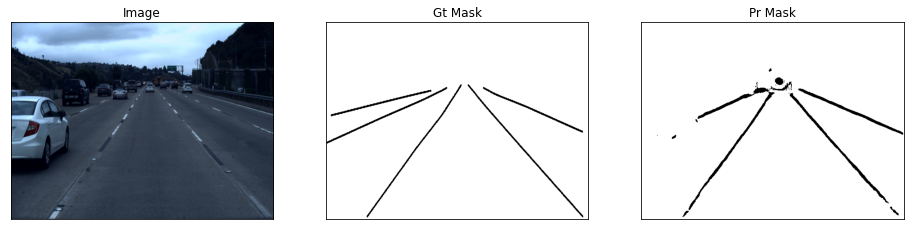

1/1 [==============================] - 0s 40ms/step


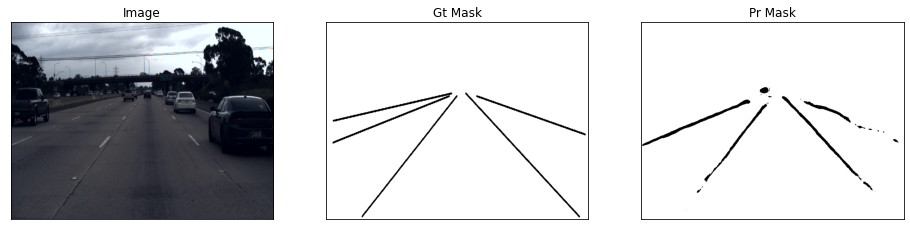

1/1 [==============================] - 0s 39ms/step


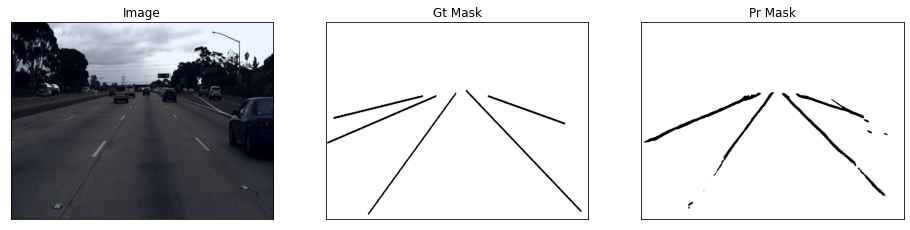

1/1 [==============================] - 0s 38ms/step


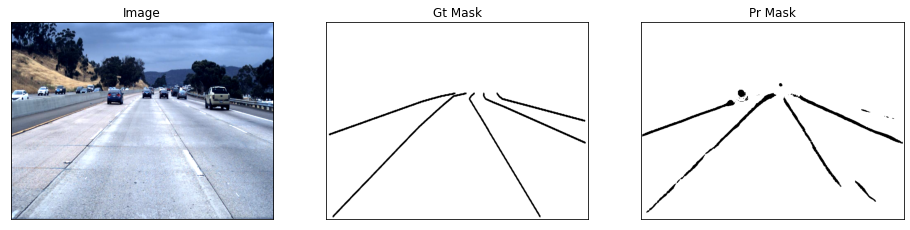

1/1 [==============================] - 0s 40ms/step


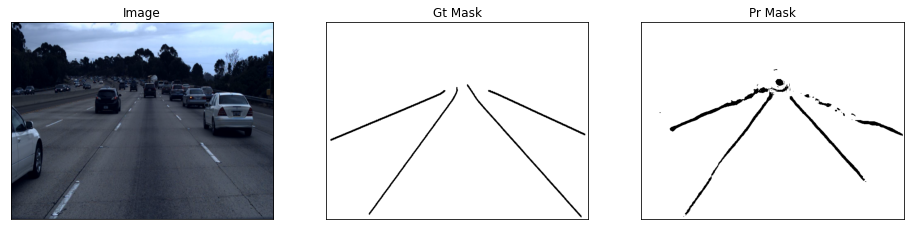

1/1 [==============================] - 0s 39ms/step


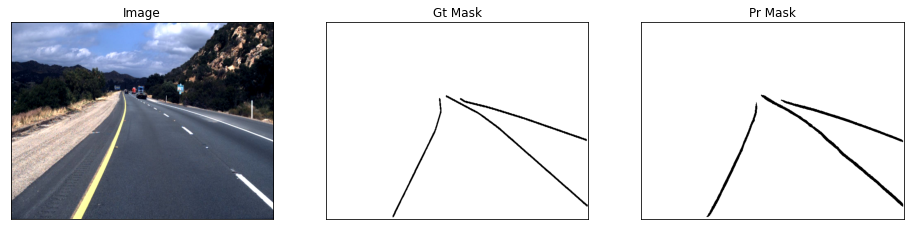

1/1 [==============================] - 0s 38ms/step


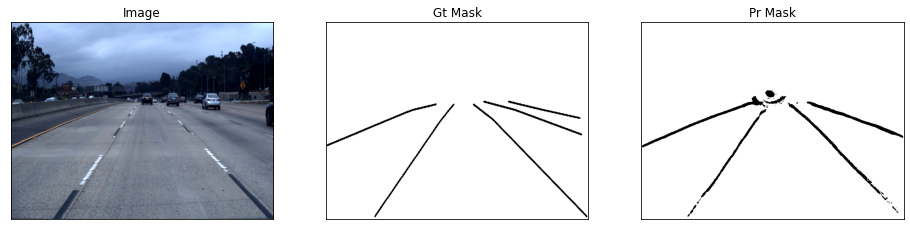

1/1 [==============================] - 0s 37ms/step


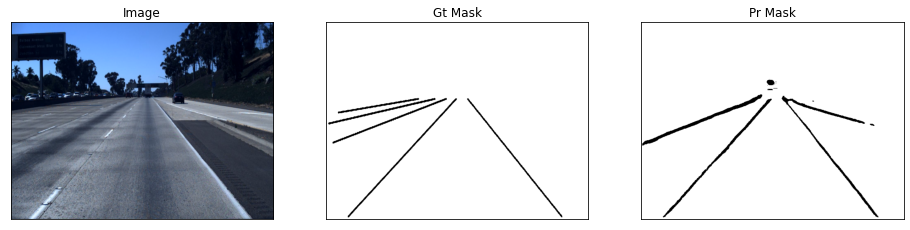

1/1 [==============================] - 0s 39ms/step


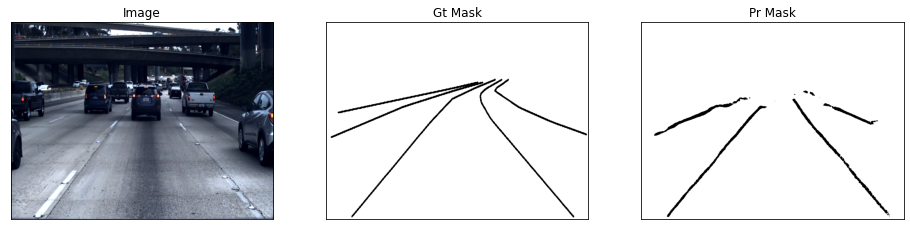

1/1 [==============================] - 0s 37ms/step


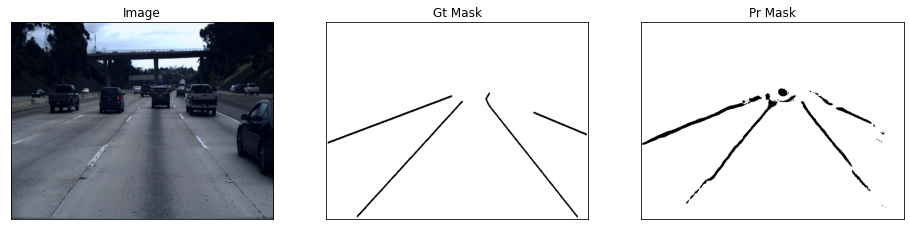

1/1 [==============================] - 0s 61ms/step


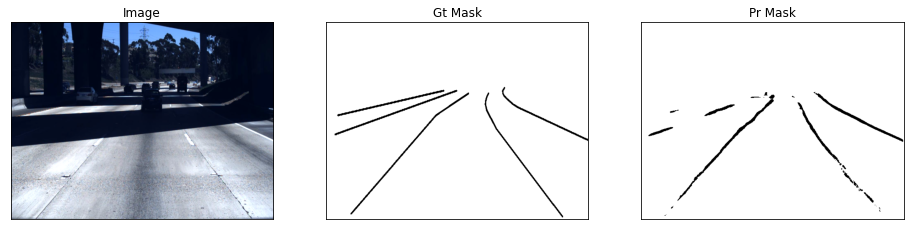

1/1 [==============================] - 0s 52ms/step


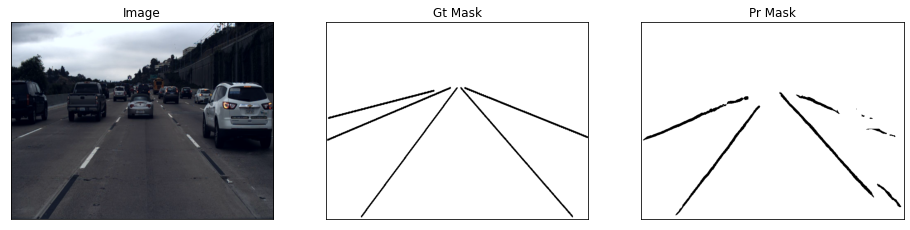

1/1 [==============================] - 0s 53ms/step


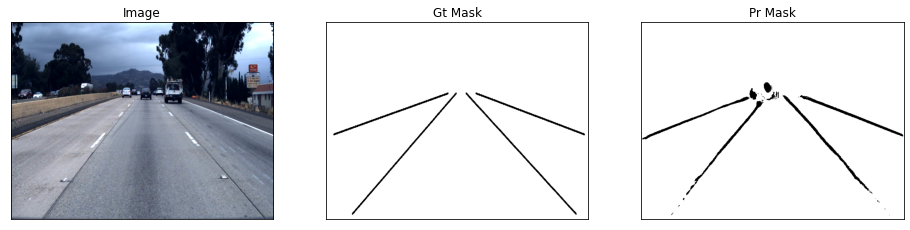

1/1 [==============================] - 0s 63ms/step


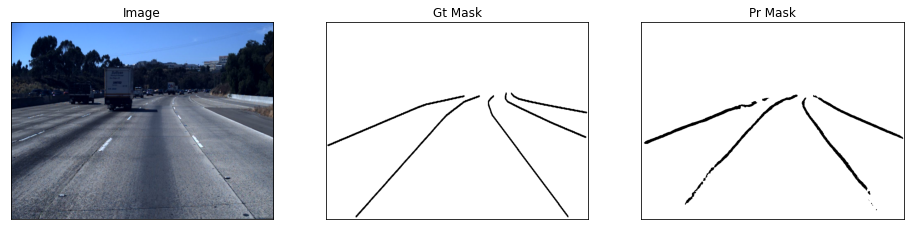

1/1 [==============================] - 0s 59ms/step


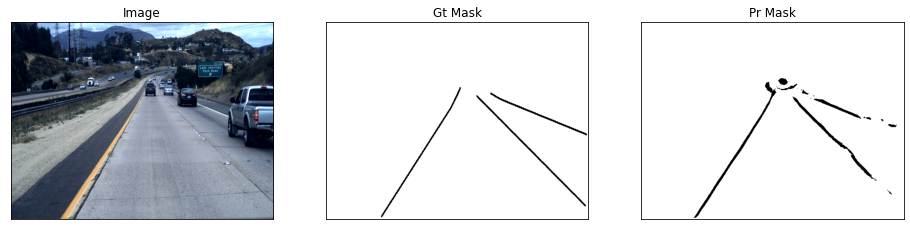

1/1 [==============================] - 0s 64ms/step


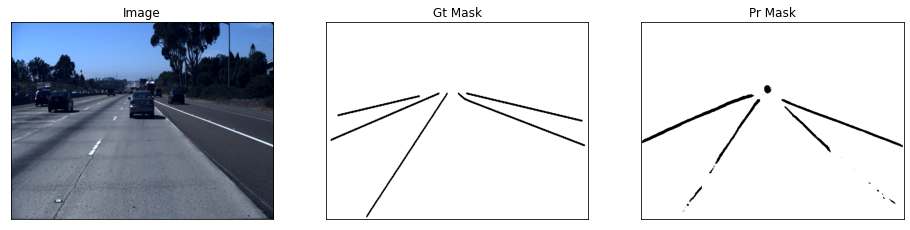

1/1 [==============================] - 0s 55ms/step


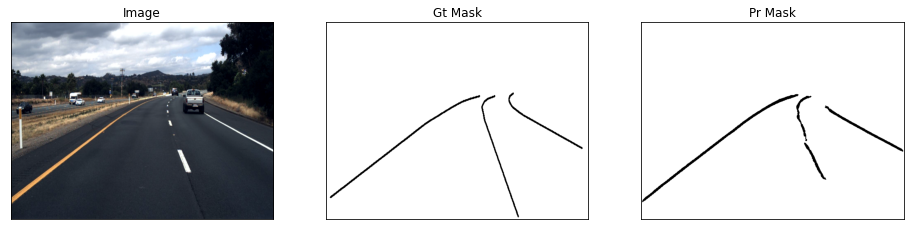

1/1 [==============================] - 0s 38ms/step


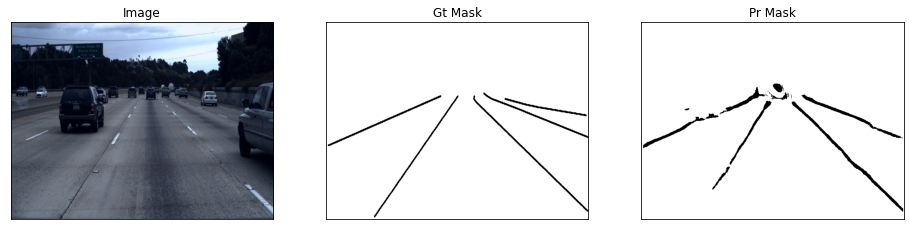

1/1 [==============================] - 0s 37ms/step


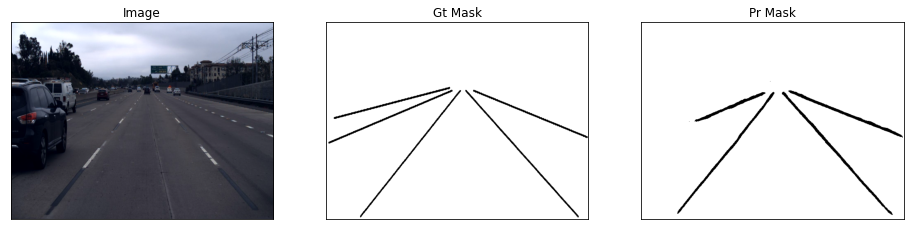

1/1 [==============================] - 0s 39ms/step


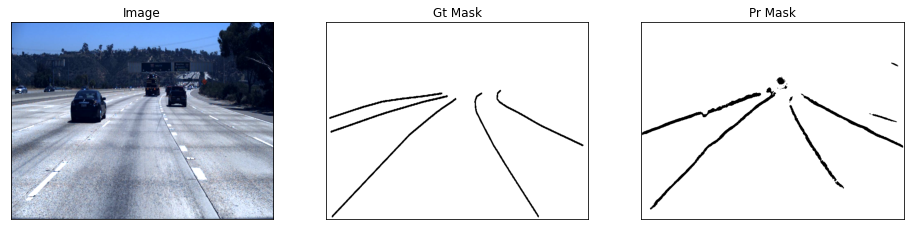

In [ ]:
n = 20
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)

for i in ids:
    
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round()
    
    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

In [ ]:
from keras import backend as K

In [ ]:
SMOOTH = 1e-5


# ----------------------------------------------------------------
#   Helpers
# ----------------------------------------------------------------

def _gather_channels(x, indexes, **kwargs):
    """Slice tensor along channels axis by given indexes"""
    # backend = kwargs['backend']
    if K.image_data_format() == 'channels_last':
        x = K.permute_dimensions(x, (3, 0, 1, 2))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 2, 3, 0))
    else:
        x = K.permute_dimensions(x, (1, 0, 2, 3))
        x = K.gather(x, indexes)
        x = K.permute_dimensions(x, (1, 0, 2, 3))
    return x


def get_reduce_axes(per_image, **kwargs):
    # backend = kwargs['backend']
    axes = [1, 2] if K.image_data_format() == 'channels_last' else [2, 3]
    if not per_image:
        axes.insert(0, 0)
    return axes


def gather_channels(*xs, indexes=None, **kwargs):
    """Slice tensors along channels axis by given indexes"""
    if indexes is None:
        return xs
    elif isinstance(indexes, (int)):
        indexes = [indexes]
    xs = [_gather_channels(x, indexes=indexes, **kwargs) for x in xs]
    return xs


def round_if_needed(x, threshold, **kwargs):
    # backend = kwargs['backend']
    if threshold is not None:
        x = K.greater(x, threshold)
        x = K.cast(x, K.floatx())
    return x


def average(x, per_image=False, class_weights=None, **kwargs):
    # backend = kwargs['backend']
    if per_image:
        x = K.mean(x, axis=0)
    if class_weights is not None:
        x = x * class_weights
    return K.mean(x)


# ----------------------------------------------------------------
#   Metric Functions
# ----------------------------------------------------------------

def iou_score(gt, pr, class_weights=1., class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):
    r""" The `Jaccard index`_, also known as Intersection over Union and the Jaccard similarity coefficient
    (originally coined coefficient de communauté by Paul Jaccard), is a statistic used for comparing the
    similarity and diversity of sample sets. The Jaccard coefficient measures similarity between finite sample sets,
    and is defined as the size of the intersection divided by the size of the union of the sample sets:

    .. math:: J(A, B) = \frac{A \cap B}{A \cup B}

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round

    Returns:
        IoU/Jaccard score in range [0, 1]

    .. _`Jaccard index`: https://en.wikipedia.org/wiki/Jaccard_index

    """

    # backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    intersection = K.sum(gt * pr, axis=axes)
    union = K.sum(gt + pr, axis=axes) - intersection

    score = (intersection + smooth) / (union + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def f_score(gt, pr, beta=1, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None,
            **kwargs):
    r"""The F-score (Dice coefficient) can be interpreted as a weighted average of the precision and recall,
    where an F-score reaches its best value at 1 and worst score at 0.
    The relative contribution of ``precision`` and ``recall`` to the F1-score are equal.
    The formula for the F score is:

    .. math:: F_\beta(precision, recall) = (1 + \beta^2) \frac{precision \cdot recall}
        {\beta^2 \cdot precision + recall}

    The formula in terms of *Type I* and *Type II* errors:

    .. math:: F_\beta(A, B) = \frac{(1 + \beta^2) TP} {(1 + \beta^2) TP + \beta^2 FN + FP}


    where:
        TP - true positive;
        FP - false positive;
        FN - false negative;

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or list of class weights, len(weights) = C
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        beta: f-score coefficient
        smooth: value to avoid division by zero
        per_image: if ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch
        threshold: value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round

    Returns:
        F-score in range [0, 1]

    """

    # backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # calculate score
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    fn = K.sum(gt, axis=axes) - tp

    score = ((1 + beta ** 2) * tp + smooth) \
            / ((1 + beta ** 2) * tp + beta ** 2 * fn + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def precision(gt, pr, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):
    r"""Calculate precision between the ground truth (gt) and the prediction (pr).

    .. math:: F_\beta(tp, fp) = \frac{tp} {(tp + fp)}

    where:
         - tp - true positives;
         - fp - false positives;

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or ``np.array`` of class weights (``len(weights) = num_classes``)
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: Float value to avoid division by zero.
        per_image: If ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch.
        threshold: Float value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round.
        name: Optional string, if ``None`` default ``precision`` name is used.

    Returns:
        float: precision score
    """
    # backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    # score calculation
    tp = K.sum(gt * pr, axis=axes)
    fp = K.sum(pr, axis=axes) - tp
    
    score = (tp + smooth) / (tp + fp + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


def recall(gt, pr, class_weights=1, class_indexes=None, smooth=SMOOTH, per_image=False, threshold=None, **kwargs):
    r"""Calculate recall between the ground truth (gt) and the prediction (pr).

    .. math:: F_\beta(tp, fn) = \frac{tp} {(tp + fn)}

    where:
         - tp - true positives;
         - fp - false positives;

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        class_weights: 1. or ``np.array`` of class weights (``len(weights) = num_classes``)
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.
        smooth: Float value to avoid division by zero.
        per_image: If ``True``, metric is calculated as mean over images in batch (B),
            else over whole batch.
        threshold: Float value to round predictions (use ``>`` comparison), if ``None`` prediction will not be round.
        name: Optional string, if ``None`` default ``precision`` name is used.

    Returns:
        float: recall score
    """
    # backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)
    pr = round_if_needed(pr, threshold, **kwargs)
    axes = get_reduce_axes(per_image, **kwargs)

    tp = K.sum(gt * pr, axis=axes)
    fn = K.sum(gt, axis=axes) - tp

    score = (tp + smooth) / (tp + fn + smooth)
    score = average(score, per_image, class_weights, **kwargs)

    return score


# ----------------------------------------------------------------
#   Loss Functions
# ----------------------------------------------------------------

def categorical_crossentropy(gt, pr, class_weights=1., class_indexes=None, **kwargs):
    # backend = kwargs['backend']

    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)

    # scale predictions so that the class probas of each sample sum to 1
    axis = 3 if K.image_data_format() == 'channels_last' else 1
    pr /= K.sum(pr, axis=axis, keepdims=True)

    # clip to prevent NaN's and Inf's
    pr = K.clip(pr, K.epsilon(), 1 - K.epsilon())

    # calculate loss
    output = gt * K.log(pr) * class_weights
    return - K.mean(output)


def binary_crossentropy(gt, pr, **kwargs):
    # backend = kwargs['backend']
    return K.mean(K.binary_crossentropy(gt, pr))


def categorical_focal_loss(gt, pr, gamma=2.0, alpha=0.25, class_indexes=None, **kwargs):
    r"""Implementation of Focal Loss from the paper in multiclass classification

    Formula:
        loss = - gt * alpha * ((1 - pr)^gamma) * log(pr)

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        alpha: the same as weighting factor in balanced cross entropy, default 0.25
        gamma: focusing parameter for modulating factor (1-p), default 2.0
        class_indexes: Optional integer or list of integers, classes to consider, if ``None`` all classes are used.

    """

    # backend = kwargs['backend']
    gt, pr = gather_channels(gt, pr, indexes=class_indexes, **kwargs)

    # clip to prevent NaN's and Inf's
    pr = K.clip(pr, K.epsilon(), 1.0 - K.epsilon())

    # Calculate focal loss
    loss = - gt * (alpha * K.pow((1 - pr), gamma) * K.log(pr))

    return K.mean(loss)


def binary_focal_loss(gt, pr, gamma=2.0, alpha=0.25, **kwargs):
    r"""Implementation of Focal Loss from the paper in binary classification

    Formula:
        loss = - gt * alpha * ((1 - pr)^gamma) * log(pr) \
               - (1 - gt) * alpha * (pr^gamma) * log(1 - pr)

    Args:
        gt: ground truth 4D keras tensor (B, H, W, C) or (B, C, H, W)
        pr: prediction 4D keras tensor (B, H, W, C) or (B, C, H, W)
        alpha: the same as weighting factor in balanced cross entropy, default 0.25
        gamma: focusing parameter for modulating factor (1-p), default 2.0

    """
    # backend = kwargs['backend']

    # clip to prevent NaN's and Inf's
    pr = K.clip(pr, K.epsilon(), 1.0 - K.epsilon())

    loss_1 = - gt * (alpha * K.pow((1 - pr), gamma) * K.log(pr))
    loss_0 = - (1 - gt) * ((1 - alpha) * K.pow((pr), gamma) * K.log(1 - pr))
    loss = K.mean(loss_0 + loss_1)
    return loss

1/1 [==============================] - 0s 38ms/step
IOU=0.96, Precision=0.99, Recall=468.38, f1=1.97


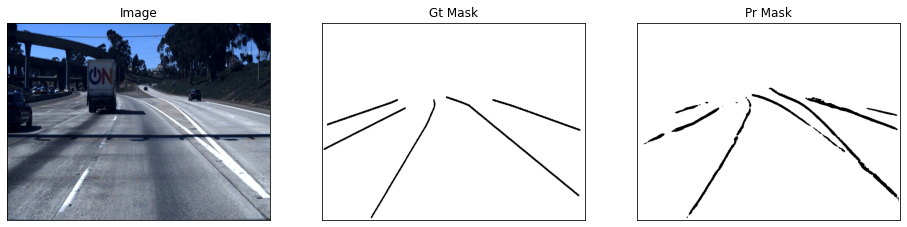

1/1 [==============================] - 0s 53ms/step
IOU=0.97, Precision=0.99, Recall=472.35, f1=1.98


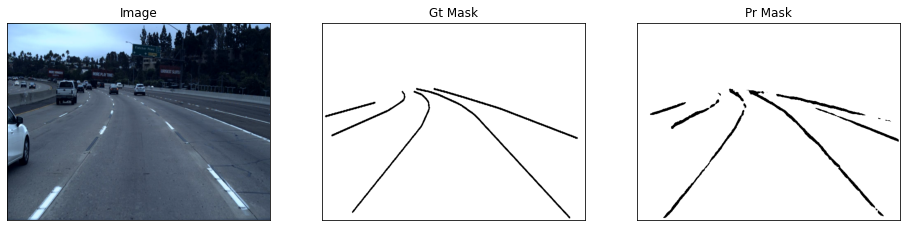

1/1 [==============================] - 0s 39ms/step
IOU=0.98, Precision=0.99, Recall=473.13, f1=1.98


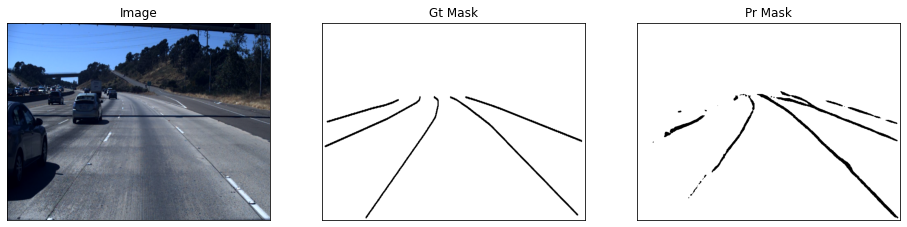

1/1 [==============================] - 0s 44ms/step
IOU=0.98, Precision=0.99, Recall=474.02, f1=1.98


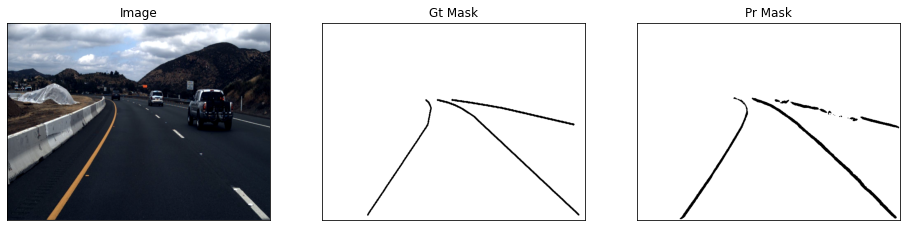

1/1 [==============================] - 0s 37ms/step
IOU=0.98, Precision=0.99, Recall=474.92, f1=1.98


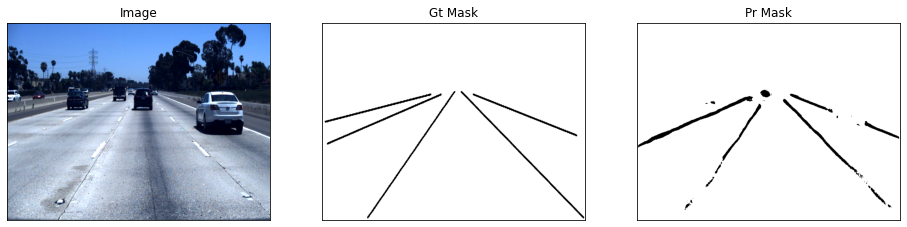

Mean IOU=0.9740739448555346, Mean Precision=0.9898667454087974, Mean Recall=472.55851468760363, Mean f1=1.975592537610829


In [ ]:
n = 326
ids = np.random.choice(np.arange(len(valid_dataset)), size=n)
iou_arr = []
precision_arr = []
recall_arr = []
f1_arr = []



for i in ids:
    image, gt_mask = valid_dataset[i]
    image = np.expand_dims(image, axis=0)
    pr_mask = model.predict(image).round().astype(float)
    
    iou = iou_score(gt_mask,pr_mask,per_image=True).numpy()
    prec = precision(gt_mask,pr_mask,per_image=True).numpy()
    rec = recall(gt_mask,pr_mask,per_image=True).numpy()
    f1 = f_score(gt_mask,pr_mask,per_image=True).numpy()

    iou_arr.append(iou)
    precision_arr.append(prec)
    recall_arr .append(rec)
    f1_arr.append(f1)
    
    print(f'IOU={iou:.2f}, Precision={prec:.2f}, Recall={rec:.2f}, f1={f1:.2f}')

    visualize(
        image=denormalize(image.squeeze()),
        gt_mask=gt_mask[..., 0].squeeze(),
        pr_mask=pr_mask[..., 0].squeeze(),
    )

print(f'Mean IOU={np.mean(iou_arr)}, Mean Precision={np.mean(precision_arr)}, Mean Recall={np.mean(recall_arr)}, Mean f1={np.mean(f1_arr)}')